In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2012 files belonging to 3 classes.


In [8]:
class_names= dataset.class_names

In [10]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

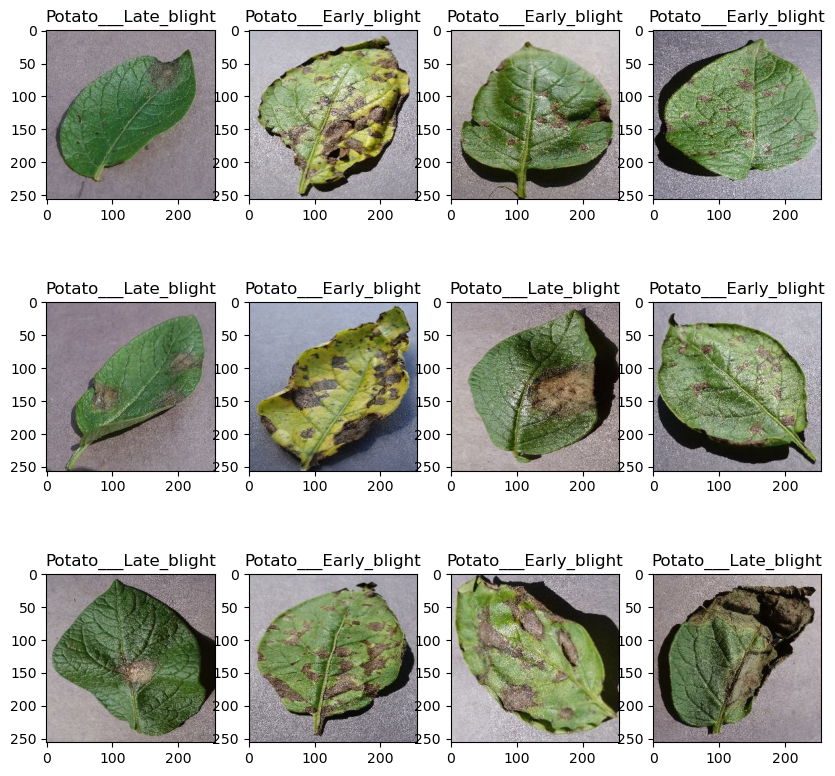

In [27]:
plt.figure(figsize=(10,10))
#we are looping through 12 images of a batch from 32 batches
for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[lable_batch[i]])
       

In [28]:
train_size=0.8
len(dataset)* train_size

50.400000000000006

In [34]:
train_ds= dataset.take(50)
test_ds= dataset.skip(50)

In [35]:
val_size=0.1

In [36]:
val_size*len(dataset)

6.300000000000001

In [37]:
val_ds=dataset.take(6)

In [38]:
test_ds=test_ds.skip(6)

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [45]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(2),
])

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)


In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [56]:
history=model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [57]:
model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
50/50 [==============================] - 98s 2s/step - loss: 0.1502 - accuracy: 0.9442 - val_loss: 0.0715 - val_accuracy: 0.9740
Epoch 2/10
50/50 [==============================] - 94s 2s/step - loss: 0.0871 - accuracy: 0.9668 - val_loss: 0.0640 - val_accuracy: 0.9792
Epoch 3/10
50/50 [==============================] - 93s 2s/step - loss: 0.0526 - accuracy: 0.9812 - val_loss: 0.0457 - val_accuracy: 0.9844
Epoch 4/10
50/50 [==============================] - 92s 2s/step - loss: 0.0423 - accuracy: 0.9837 - val_loss: 0.0459 - val_accuracy: 0.9844
Epoch 5/10
50/50 [==============================] - 92s 2s/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.0425 - val_accuracy: 0.9844
Epoch 6/10
50/50 [==============================] - 93s 2s/step - loss: 0.0169 - accuracy: 0.9969 - val_loss: 0.0542 - val_accuracy: 0.9844
Epoch 7/10
50/50 [==============================] - 95s 2s/step - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.1089 - val_accuracy: 0.9583
Epoch 8/10
50/50 [==

In [58]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 3s 391ms/step - loss: 0.0986 - accuracy: 0.9688
